# 02-750 HW 3 
## Exercise 1
### Anushka Sinha (anushka3)

### Imports

In [39]:
import pandas as pd 
import numpy as np
import math
import copy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import random
from tqdm import tqdm
from numpy import savetxt

### Data

In [40]:
data = pd.read_csv("ex2_data.csv")
data_array = data.to_numpy()
features = (data.iloc[:,:-1]).to_numpy()
labels = (data.iloc[:, -1]).to_numpy()


In [41]:
random_seeds = []
for i in range(10):
    random.seed(100*i)
    random_seeds.append(random.randint(1, 100))
random_seeds

[50, 19, 6, 77, 40, 60, 34, 22, 86, 80]

### 2a. Implement ONE of the following three Type II algorithms (ZLG, DH, or PLAL)
### Below is an implementation of the ZLG algorithm

In [42]:
sig = 1
t = 0.005

In [44]:
def run_cross_fold_validation(model, train_X, train_y, seed):
    
    """ 
    Split your training data at that round into 5 different sets of equal size (or as equal as they can be). 
    Train a model using 4 of the 5 sets. Assess that model on the remaining set. 
    Continue this process until each set has been used for assessment once. 
    Add up the errors from all 5 folds and divide by the total number of observed instances. 
    This will yield an average error that will not be severely biased by imbalances in the fold sizes. 
    This will give you a good estimate of the model performance given the data you have available to you at that round. 
    This will not necessarily give you an estimate of generalization performance
  """
    # Initialize KFold with 5 splits
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    fold_accuracies = []

    for train_idx, test_idx in kf.split(train_X):
        # Split the data into training and testing sets for this fold
        X_train_fold, X_test_fold = train_X[train_idx], train_X[test_idx]
        y_train_fold, y_test_fold = train_y[train_idx], train_y[test_idx]

        # Train a model on the training fold
        model.fit(X_train_fold, y_train_fold)

        # Predict on the testing fold
        y_pred_fold = model.predict(X_test_fold)

        # Calculate accuracy for this fold
        fold_accuracy = accuracy_score(y_test_fold, y_pred_fold)
        fold_accuracies.append(fold_accuracy)  # Store error rate

    # Calculate average error across all folds
    avg_acc = sum(fold_accuracies) / len(fold_accuracies)
    return avg_acc

In [45]:
# Creating a weight matrix
def get_weight_matrix(d):
    mat = np.zeros((len(d),len(d)))
    for i in range(len(d)):
        for j in range(673):
            dist = np.linalg.norm(d[i]-d[j])**2
            w = math.exp(-dist/(sig*sig))
            if w > t:
                mat[i,j] = w
    return mat
weight_mat = get_weight_matrix(features)

In [46]:
# Getting ∆ = D − W which is the Laplacian Matrix
def laplacian(W):
    d = []
    for i in range(len(W)):
        d.append(np.sum(W[i]))
    D = np.diag(d)
    return (D-W)
delta = laplacian(weight_mat)

In [47]:
# Reorganize the Laplacian Matrix according to the groups of labeled and unlabeled instances
def laplacian_lu(labeled, unlabeled):
    mat = np.zeros((len(delta),len(delta)))
    a = len(labeled)
    for i in range(len(delta)):
        for j in range(len(delta)):
            if (i<a) and (j<a):
                mat[i,j] = delta[labeled[i],labeled[j]]
            elif (i<a) and (j>=a):
                mat[i,j] = delta[labeled[i], unlabeled[j-a]]
            elif (i>=a) and (j<a):
                mat[i,j] = delta[unlabeled[i-a], labeled[j]]
            else:
                mat[i,j] = delta[unlabeled[i-a], unlabeled[j-a]]
    return mat


In [48]:
# Compute the vector that contains minimum energy solution for the unlabeled instances
def f_u(lu, f_l):
    a = len(f_l)
    preds = -np.matmul(np.matmul(np.linalg.inv(lu[a:,a:]), lu[a:, :a]), f_l)
    return preds
#
def risk(f):
    s = 0
    for i in f:
        s += min(i, 1-i)
    return s

In [49]:
# Compute the expected estimated risk if we were to request the label for node k
def risk_hat(lu, f_l, ind, y_k, labeled, unlabeled): 
    a = len(f_l)
    if ind != 0:
        replacer_col = np.copy(lu[:,a+ind])
        replaced_col = np.copy(lu[:, a])
        lu[:,a] = replacer_col
        lu[:, a+ind] = replaced_col
        replacer_row = np.copy(lu[a+ind, :])
        replaced_row = np.copy(lu[a, :])
        lu[a, :] = replacer_row
        lu[a+ind, :] = replaced_row
    l_new = []
    for i in f_l:
        l_new.append(i)
    l_new.append(y_k)
    l_new = np.array(l_new)
    u_new = f_u(lu, l_new)
    return risk(u_new)

In [50]:
# Get the instance that minimizes the future estimated risk
def least_risk(lu, f_l, f_u, labeled, unlabeled):
    risks = [-1, math.inf]
    for ind, k in enumerate(unlabeled):
        risk = (1-f_u[ind])*risk_hat(lu, f_l, ind, 0, labeled, unlabeled) + f_u[ind]*risk_hat(lu, f_l, ind, 1, labeled, unlabeled)
        if risk < risks[1]:
            risks = [k, risk]
    return risks[0]

In [51]:
def ZLG(dataset, seed, features, labels):
    cross_fold_performance = []
    
    # Take initial 20% data (random observations)
    training_size = len(delta)//5
    labeled_indices = np.random.choice(len(delta), training_size, replace= False)

    unlabeled_indices = []
    for i in range(len(delta)):
        if not(i in labeled_indices):
            unlabeled_indices.append(i)

    
    sample_data_X, sample_data_y  = features[labeled_indices], labels[labeled_indices]
    remaining_data = dataset[unlabeled_indices]
    remaining_data_X, remaining_data_y = features[unlabeled_indices], labels[unlabeled_indices]

    base_learner_model = RandomForestClassifier(random_state=None)
    # Run until all observations are added:
    while len(remaining_data_X) > 0:
        cv_accuracy = run_cross_fold_validation(base_learner_model, sample_data_X, sample_data_y, seed)
        cross_fold_performance.append(cv_accuracy)

        lu = laplacian_lu(labeled_indices, unlabeled_indices)
        predictions = f_u(lu, sample_data_y)
        # Select an instance to add 
        instance_to_add = least_risk(lu, sample_data_y, predictions, labeled_indices, unlabeled_indices)
        # Get the data of the instance to add
        instance_X, instance_y = features[instance_to_add], labels[instance_to_add]
        # Add the queried instance to the training set
        sample_data_X = np.append(sample_data_X, [instance_X], axis=0)
        sample_data_y = np.append(sample_data_y, [instance_y], axis=0)
        labeled_indices = np.append(labeled_indices, instance_to_add)
        unlabeled_indices.remove(instance_to_add)
    
        # Remove the queried instance from the pool
        remaining_data = dataset[unlabeled_indices]
        remaining_data_X, remaining_data_y = features[unlabeled_indices], labels[unlabeled_indices]
        # Retrain the model on the updated training set
        base_learner_model.fit(sample_data_X, sample_data_y)
    return cross_fold_performance


In [52]:
# Running ZLG
cross_fold_accuracies_ZLG = []

for seed in tqdm(random_seeds):
    cv_acc = ZLG(data_array, seed, features, labels)
    cross_fold_accuracies_ZLG.append(cv_acc)

avg_acc_ZLG = np.mean(cross_fold_accuracies_ZLG, axis=0)
savetxt('avg_acc_ZLG.csv', avg_acc_ZLG, delimiter=',')
std_acc_ZLG = np.std(cross_fold_accuracies_ZLG, axis=0)
savetxt('std_acc_ZLG.csv', std_acc_ZLG, delimiter=',')
x_values_ZLG = list(range(len(cv_acc)))
savetxt('x_vals_ZLG.csv', x_values_ZLG, delimiter=',')

100%|██████████| 10/10 [2:22:37<00:00, 855.70s/it] 


/tmp/ipykernel_31718/778064633.py:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(x_values_ZLG, avg_acc_ZLG, yerr=std_acc_ZLG, fmt='-o', linestyle='-', label="ZLG")


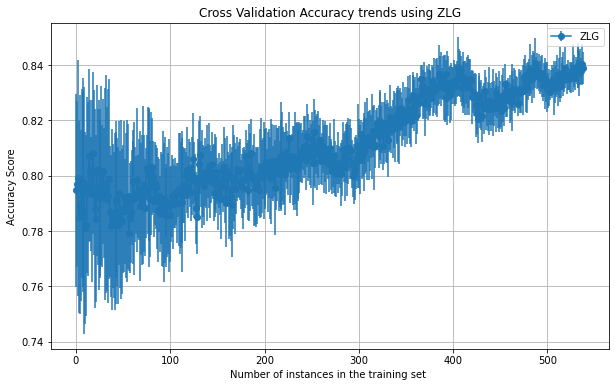

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.errorbar(x_values_ZLG, avg_acc_ZLG, yerr=std_acc_ZLG, fmt='-o', linestyle='-', label="ZLG")

plt.title('Cross Validation Accuracy trends using ZLG')
plt.xlabel('Number of instances in the training set ')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid(True)
plt.show()


### 2b. Comment on the results in part 2a compare against any of the Type I algorithms implemented in previous homework assignments
### Comparing to Minimization of Expected Risk (MER)

In [54]:
def calc_expected_risk(model, old_train_X, old_train_y, unlabeled_pool_X, old_probs):
    labels = [0., 1.]
    # Store (index, label) as key and probabilities as values
    probabilities = dict()

    for index, instance in enumerate(unlabeled_pool_X):
        # Delete this instance from the unlabeled pool
        updated_unlabeled_pool_X = np.delete(unlabeled_pool_X, index, axis=0)
        if updated_unlabeled_pool_X.shape[0] == 0:
            # Skip this iteration if there are no samples left
            continue
        # Add this instance to the train set
        new_train_X = np.append(old_train_X, instance.reshape(1, -1), axis=0)
        # Loop through every label for this instance
        for label in labels:
            # Train the model on the updated train_X and train_y
            new_train_y = np.append(old_train_y, np.array([label]), axis=0)
            model.fit(new_train_X, new_train_y)
            # Get probabilities for the every instance except the instance we are working with 
            probs = model.predict_proba(updated_unlabeled_pool_X)
            probs = np.insert(probs, index, 1.0, axis = 0)
            max_probs = np.max(probs, axis=1)
            # Store the probabilities obtained for this specific pair of instance and label
            probabilities[(index, label)] = max_probs
    
    all_ER = []  
    for i, pred in enumerate(old_probs):
        summand = 0
        for j in range(len(pred)):
            key = (i, j)
            val_class = sum(1 - row for row in probabilities[key])
            summand += val_class * pred[j]
        all_ER.append(summand)

    query_idx = np.argmin(all_ER)
    return query_idx

In [55]:
def minimizing_expected_risk(dataset, seed):
    cross_fold_performance = []

    sample_data, remaining_data = train_test_split(dataset, test_size=0.8, random_state=seed)
    sample_data_X, sample_data_y = sample_data[:, :-1], sample_data[:, -1]
    remaining_data_X, remaining_data_y = remaining_data[:, :-1], remaining_data[:, -1]

    # Initialize and fit the model
    base_learner_model = RandomForestClassifier(n_estimators = 5, random_state=42)
    base_learner_model.fit(sample_data_X, sample_data_y)
   
    # Run until all observations are added:
    while len(remaining_data) > 1:
        # print("before", len(remaining_data))
        
        cv_accuracy = run_cross_fold_validation(base_learner_model, sample_data_X, sample_data_y, seed)
        cross_fold_performance.append(cv_accuracy)
        
        # Select an instance to add = hard_vote_entropy()
        probs = base_learner_model.predict_proba(remaining_data_X)
        instance_to_add = calc_expected_risk(base_learner_model, sample_data_X, sample_data_y, remaining_data_X, probs)
        
        # Get the data of the instance to add
        instance_X, instance_y = remaining_data_X[instance_to_add], remaining_data_y[instance_to_add]
        # Add the queried instance to the training set
        sample_data_X = np.append(sample_data_X, [instance_X], axis=0)
        sample_data_y = np.append(sample_data_y, [instance_y], axis=0)
        
        # Remove the queried instance from the pool
        remaining_data = np.delete(remaining_data, instance_to_add, axis=0)
        remaining_data_X, remaining_data_y = remaining_data[:, :-1], remaining_data[:, -1]
        remaining_indices = list(range(len(remaining_data_X)))
        # print("after", len(remaining_data))
        
    return cross_fold_performance # length 120

In [56]:
# Running MER
cross_fold_accuracies_MER = []

for seed in tqdm(random_seeds):
    cv_acc = minimizing_expected_risk(data_array, seed)
    cross_fold_accuracies_MER.append(cv_acc)
  
avg_acc_MER = np.mean(cross_fold_accuracies_MER, axis=0)
savetxt('avg_acc_MER.csv', avg_acc_MER, delimiter=',')
std_acc_MER = np.std(cross_fold_accuracies_MER, axis=0)
savetxt('std_acc_MER.csv', std_acc_MER, delimiter=',')
x_values_MER = list(range(len(cv_acc)))
savetxt('x_vals_MER.csv', x_values_MER, delimiter=',')


100%|██████████| 10/10 [3:41:50<00:00, 1331.04s/it] 


/tmp/ipykernel_31718/1541594086.py:3: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(x_values_ZLG, avg_acc_ZLG, yerr=std_acc_ZLG, fmt='-o', linestyle='-', label="ZLG")
/tmp/ipykernel_31718/1541594086.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(x_values_MER, avg_acc_MER, yerr=std_acc_MER, fmt='-o', linestyle='-', label="MER")


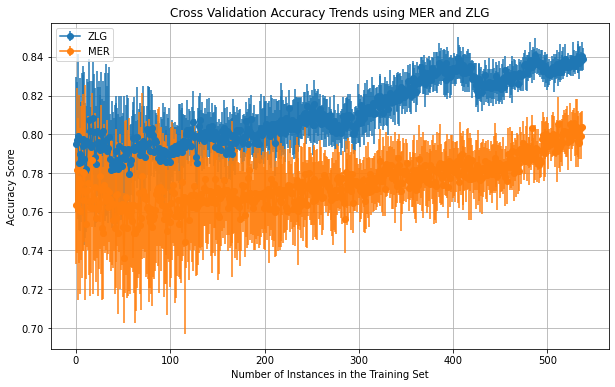

In [57]:
plt.figure(figsize=(10, 6))

plt.errorbar(x_values_ZLG, avg_acc_ZLG, yerr=std_acc_ZLG, fmt='-o', linestyle='-', label="ZLG")
plt.errorbar(x_values_MER, avg_acc_MER, yerr=std_acc_MER, fmt='-o', linestyle='-', label="MER")
plt.title('Cross Validation Accuracy Trends using MER and ZLG')
plt.xlabel('Number of Instances in the Training Set')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid(True)
plt.show()